# Arima 8:2

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


In [2]:
# Thư viện
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Đọc file
df = pd.read_excel('bnb_processed_data.xlsx')

In [4]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [5]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1914,2024-05-27,599.825928,613.388184,599.700745,603.526428,603.526428,1691663828
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745


In [6]:
# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra(8:2)
# Kích thước tập dữ liệu "Close"(8:2)
train_size = int(0.8*len(time_series_Close))
# Giá trị tập từ liệu "Close" (8:2)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:]
# Lấy index (8:2)
index_train_data = train_data.index
index_test_data = test_data.index
last_index = index_test_data.max()

In [ ]:
auto_arima(train_data, start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=14.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=13488.860, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12906.946, Time=1.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=12.93 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13463.420, Time=0.39 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12764.280, Time=3.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=29.47 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=10.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=12790.571, Time=1.49 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=12751.764, Time=2.72 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=12892.681, Time=1.44 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=32.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=12.97 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=12752.463, Time=3.53 sec
 ARIMA(2,1,1)(2,1,0)[12]           

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [7]:
# Huấn luyện model
model = ARIMA(train_data, order=(0,1,2))
fit_model= model.fit()
# Prediction trên tập kiểm tra
predictions = fit_model.forecast(steps=len(test_data))
# Dự đoán 30/60/90
forecast_90 = fit_model.forecast(steps=90)

In [8]:
# Đưa dựa đoán vào index
time_series_Close_90 = df['Close'].copy()
time_series_Close_90 = pd.concat([time_series_Close_90, forecast_90])
forecast_90 = time_series_Close_90.iloc[-90:]
forecast_90.index = range(last_index+1, last_index+91)
forecast_90

1919    310.620784
1920    310.958650
1921    310.958650
1922    310.958650
1923    310.958650
           ...    
2004    310.958650
2005    310.958650
2006    310.958650
2007    310.958650
2008    310.958650
Length: 90, dtype: float64

In [9]:
# Xác định kích thước mỗi phần
split_size = len(forecast_90) // 3
forecast_values_30day = forecast_90[:split_size]
forecast_values_60day = forecast_90[split_size:2*split_size]
forecast_values_90day = forecast_90[2*split_size:]

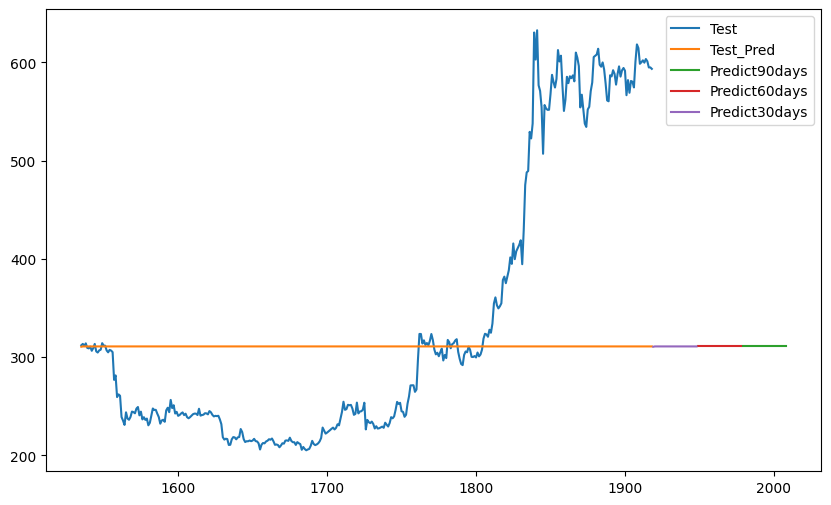

In [12]:
# Trực quan hóa kết quả
plt.figure(figsize=(10, 6))
plt.plot(test_data.index,test_data, label='Test')
plt.plot( predictions, label='Test_Pred')
plt.plot(forecast_values_90day.index, forecast_values_90day,label='Predict90days')
plt.plot(forecast_values_60day.index, forecast_values_60day,label='Predict60days')
plt.plot(forecast_values_30day.index, forecast_values_30day, label='Predict30days')
plt.legend()
plt.show()

In [11]:
# Tính toán RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
# Tính toán MAE
mae = mean_absolute_error(test_data, predictions)
# Tính toán MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_data, predictions)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 141.26647149291256
MAE: 106.90826431210137
MAPE: 30.017698372092433
